# GMM para Speech features

## Importando libs

In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.stats import multivariate_normal
import math
from numpy import linalg as LA
import matplotlib.cm as cm
import matplotlib.mlab as mlab

%matplotlib inline

## Inicializando variáveis globais

In [2]:
Ng = 3
test_size = .2

## Lendo os dados MFCC do arquivo

In [3]:
target_frame_sanderson = pd.read_csv('data/feature_lib.csv')
target_frame_sanderson.fillna(0, inplace=True)
y = target_frame_sanderson.iloc[:, 1].values
X = target_frame_sanderson.iloc[:, 2:100].values
y, X

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,
         1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.]),
 array([[ 16.06516658,  -6.167928  , -11.60263281, ...,   9.73565104,
          -6.01127765,  -0.39201773],
        [ 15.52645668,  -5.77143651,  -8.6210234 , ...,  25.84498242,
          -4.89838865,  11.15632049],
        [ 15.90670822,  -0.70229411, -11.62260717, ...,   1.67244094,
          -9.22338872,  -0.79974016],
        ..., 
        [ 16.03676337,  -3.01418019,  -2.49913762, ...,  14.47599253,
          -1.42811305,   2.77662196],
        [ 19.67184283, -14.94721738, -16.43764792, ...,   8.47230223,
          -9.10652143,   2.46218451],
        [ 16.03121297,  -3.3894565 , -12.06090029, ...,  14.06559439,
          -4.03672792,  -6.78197443]]))

## Separando treino e teste para validação cruzada

In [4]:
data, tar = X, y

def get_key(t):
    return t[1]

res = list(zip(data, tar))
res = sorted(res, key=get_key)
data, tar = list(zip(*res))
d0 = data[0:10]
d1 = data[10:20]
d2 = data[20:30]

t0 = tar[0:10]
t1 = tar[10:20]
t2 = tar[20:30]

dataset, target = np.array([d0, d1, d2]), np.array([t0, t1, t2])

n_interaction = [round(len(d) * test_size) for d in dataset]

data_tes = []
target_tes = []
data_train = []
target_train = []
for d in range(0, len(dataset)):
    for i in range(0, n_interaction[d]):
        rand_i = random.randint(0, len(dataset[d]) - 1)
        data_tes.append(dataset[d][rand_i])
        target_tes.append(target[d][rand_i])
        new_dataset = np.delete(dataset[d], rand_i, axis=0)
        new_target = np.delete(target[d], rand_i, axis=0)
    data_train.append(new_dataset)
    target_train.append(new_target)
X_train, y_train, X_test, y_test = data_train, target_train, data_tes, target_tes

## Dividindo o treinamento em classes

In [5]:
c0, c1, c2 = X_train

c0 = np.array(c0)
c1 = np.array(c1)
c2 = np.array(c2)

data = c0

## Gerando modelo para uma classe

###  Usando Kmeans para melhor inicialização

#### Categorizar cada vetor com a média mais próxima

In [6]:
def __min_norm_gauss(mu, Xi):
    norms = [LA.norm(mu[g] - Xi) for g in range(0, Ng)]
    return norms.index(min(norms))

def __min_index_gauss(mu, data):
    return [__min_norm_gauss(mu, data[i]) for i in range(0, len(data))]

#### Calculando médias (centros das gaussianas)

In [7]:
max_interation = 10

def __means(X):
    def __new_mu(data, delta_kronecker):
        gf = [delta_kronecker(i) for i in range(0, len(data))]
        if sum(gf) == 0:
            return 0, np.zeros(len(data[0]))
        mu_updated = (1 / sum(gf)) * sum([data[ix] * y for ix, y in enumerate(gf)])
        return sum(gf), mu_updated

    mu = [random.choice(X) for i in range(0, Ng)]

    loop = 1
    finished = False
    yi = []
    ng = []
    while not finished:
        yi = __min_index_gauss(mu, X)
        res = [__new_mu(X, lambda ix: yi[ix] == g) for g in range(0, Ng)]
        ng, mu_new = zip(*res)
        ng = list(ng)
        mu_new = list(mu_new)

        same = all([np.array_equal(mu[g], mu_new[g]) for g in range(0, Ng)])
        loop = loop + 1
        finished = same or loop > max_interation

        mu = mu_new
    return ng, mu, yi
    
__means(data)

([2, 2, 5], [array([  1.60267160e+01,  -1.64728610e+00,  -2.60502167e+00,
           8.68734422e+00,   1.10267449e+01,   5.46951501e+00,
           2.09874731e+00,   4.81691411e+00,   3.23687712e+00,
           1.93848598e+00,   3.17000478e-01,   1.94064945e-01,
          -6.87370222e-03,   1.54909662e+01,  -1.41027276e-01,
          -4.27974518e+00,   6.32046136e+00,   1.47629482e+01,
           3.97179066e+00,   3.23989699e+00,   2.13413230e+00,
           3.13062985e+00,   3.29531144e+00,   1.41830306e+00,
           5.07725790e-01,  -1.88819077e-01,   1.53889923e+01,
          -7.99947899e-01,  -5.24740297e+00,   4.60470913e+00,
           1.35566373e+01,   3.47913197e+00,   2.27681563e+00,
           9.64540381e-01,   3.27176221e+00,   3.20492325e+00,
           1.75271488e+00,   6.10156377e-01,  -1.32628387e-01,
           1.54225706e+01,  -4.00950913e-01,  -3.52961153e+00,
           6.60491174e+00,   1.51864183e+01,   3.99746821e+00,
           1.93213696e+00,   8.65135816e-01,

#### Calcula o peso e matriz de covariancia

In [8]:
def kmeans(data):
    ng, mu, y = __means(data)
    mg = [ng[g] / len(data) for g in range(0, Ng)]
    sigmas = [np.cov((data).T) for g in range(0, Ng)]
    sigmas = np.array(sigmas) 
    return mg, mu, sigmas

kmeans(data)

([0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 [array([  1.66991317e+01,  -1.36544273e+00,  -1.03550904e+01,
          -2.29487442e+00,   1.03859725e+00,  -1.15395927e+01,
          -5.17274037e-01,  -1.55518352e+00,   1.93749160e+00,
           9.22233486e-01,  -7.32876546e-01,   1.03709617e+00,
          -2.27002828e-02,   1.67832523e+01,  -2.34175877e+00,
          -1.11949784e+01,  -2.05071699e+00,   1.74676890e+00,
          -1.17862299e+01,   5.71480179e-01,  -2.88873971e+00,
           1.82407994e+00,   1.68777660e+00,  -8.19653198e-01,
           1.25160370e+00,  -6.29322126e-02,   1.68853698e+01,
          -1.54494675e+00,  -1.13978523e+01,  -1.51057078e+00,
           4.58765326e+00,  -1.09852728e+01,   6.12596914e-01,
          -2.95580414e+00,   3.48439638e+00,   2.46611077e+00,
          -1.81557964e+00,   6.07662053e-01,  -2.63011936e-01,
           1.71656228e+01,  -3.11005064e+00,  -1.26001521e+01,
          -2.56982285e+00,   3.05338302e+00,  -6.905228

### Funçoes para obter PDF da gaussiana dada lambda

In [9]:
    def gauss(x, u, e):
        e += 0.3 * np.identity(len(e))
        res = multivariate_normal(u, e)
        return res.pdf(x)

    def weighted_gauss(x, m, u, e):
        return m * gauss(x, u, e)

    def sum_weighted_gauss(x, lamb):
        acc = []
        for g in range(0, Ng):
            m_arr = lamb[0]
            u_arr = lamb[1]
            e_arr = lamb[2]
            acc.append(weighted_gauss(x, m_arr[g], u_arr[g], e_arr[g]))
        return sum(acc)

    def get_prob(data, lamb):
        acc = []
        for i in range(0, len(data)):
            acc.append(sum_weighted_gauss(data[i], lamb))
        return sum(acc)

    def get_prob_log( data, lamb):
        acc = []
        for i in range(0, len(data)):
            acc.append(math.log(sum_weighted_gauss(data[i], lamb)))
        return sum(acc)

## Maximizar lambda

In [10]:
def calc_lg(data, lamb, g):
    for i in range(0, len(data)):
        aux1 = weighted_gauss(data[i], lamb[0][g], lamb[1][g], lamb[2][g])
        aux2 = sum_weighted_gauss(data[i], lamb)
        yield aux1 / aux2

def __expectation_maximization(X, lam):

    def ug_concat(x, lg_aux): return [x[i] * lg_aux[i] for i in range(0, len(x))]

    def safe_div(x, y):
        if y == 0:
            return 0
        return x / y

    lgi = [list(calc_lg(X, lam, g)) for g in range(0, Ng)]
    lg = [sum(lgi[g]) for g in range(0, Ng)]

    weight = [lg[g] / len(X) for g in range(0, Ng)]
    mu = [(safe_div(1, lg[g]) * sum(ug_concat(X, lgi[g]))) for g in range(0, Ng)]
    sigma = [np.cov((X - mu[g]).T) for g in range(0, Ng)]

    return weight, mu, sigma

## Máxima verossimilhança (EM)

In [11]:
def __maximum_likelihood( X, lamb):
    for i in range(0, max_interation):
        p_old = get_prob_log(X, lamb)
        lamb_new = __expectation_maximization(X, lamb)
        p_new = get_prob_log(X, lamb_new)
        if p_new > p_old:
            lamb = lamb_new
    return lamb

## Criar uma função para gerar os modelos

In [12]:
def model(data):
    lamb = kmeans(data)
    return __maximum_likelihood(data, lamb)

model(data)

([0.00060165456803263977, 0.0012951099206211108, 2.7531615502499229],
 [array([  1.55264720e+01,  -5.77119013e+00,  -8.62117106e+00,
           4.52338553e+00,   1.23431182e+01,  -6.48958296e-01,
           3.74216444e+00,   2.48023122e+00,  -4.87949872e-01,
          -1.10238733e+00,  -5.83618962e-01,   5.70031151e-02,
           2.55348260e-03,   1.56510417e+01,  -5.42762332e+00,
          -9.82074373e+00,   3.94213820e+00,   1.58943550e+01,
          -1.04457353e+00,   2.85533632e+00,   1.96435597e+00,
           4.91935747e-01,  -1.63365700e+00,   8.56227751e-02,
           9.41302236e-01,   1.99327203e-01,   1.56508284e+01,
          -5.75602152e+00,  -1.06654760e+01,   2.31101899e+00,
           1.47843819e+01,   1.84136493e+00,   9.24250244e-01,
          -1.12445887e+00,  -2.05305230e+00,  -2.33654674e+00,
           1.55752922e-01,   7.91343318e-01,   3.99659734e-02,
           1.56787133e+01,  -4.38477194e+00,  -9.20473348e+00,
           4.14023486e+00,   1.62254061e+01,   4

## Criar um modelo para cada classe

In [13]:
models = [model(c0), model(c1), model(c2)]
models

[([6.4221519211645219e-10, 1.4060017702682084e-06, 2.7531682734733836],
  [array([  1.59043889e+01,  -7.32572498e-01,  -1.16047193e+01,
           -5.12859460e+00,   2.44879674e+00,  -6.43854461e+00,
            3.74065580e+00,   2.12262563e+00,   1.75137484e+00,
           -2.28856202e-01,  -2.05841474e-01,   1.26426979e+00,
            3.23104588e-01,   1.62693241e+01,  -1.64239444e+00,
           -1.16751019e+01,  -2.70339623e+00,   3.08103702e+00,
           -8.63506179e+00,   5.82576306e+00,  -3.36839738e-01,
            1.14843119e+00,   1.89726021e-01,  -1.49667503e+00,
            1.15958175e+00,  -8.70950253e-02,   1.64771276e+01,
           -1.35739899e+00,  -1.26786644e+01,  -2.26837673e+00,
            6.46235672e+00,  -1.04882022e+01,   2.68739067e+00,
           -2.36241416e+00,   3.23960989e+00,   1.63535754e+00,
           -2.08801711e+00,   6.47211662e-01,  -1.39123301e-01,
            1.63641441e+01,  -1.51201116e+00,  -1.34254049e+01,
           -3.34924495e+00,   7.

## Gerando modelo do impostor 

In [14]:
data_impostor = np.concatenate([c0, c1, c2])
umb = model(data_impostor)

## Encontrar melhor classe dado modelos (predict)

In [15]:
def find_best_class(data, models):
    best_p = 0
    best_class = -1
    for c in range(0, len(models)):
        client = models[c]
        p = sum_weighted_gauss(data, client)
        if p > best_p:
            best_p = p
            best_class = c
    return best_class


## Comparar com impostor

In [16]:
def compare_with_impostor(data, client, impostor):
    prob_client = sum_weighted_gauss(data, client)
    prob_impostor = sum_weighted_gauss(data, impostor)

    return prob_client > prob_impostor

## Utilizar dados para treinamento e comparar com esperado

In [26]:
def compare(data_test, target_test, models):
    accepts = []
    impostors = []
    for ix in range(0, len(data_test)):
        data = data_test[ix]
        target = target_test[ix]
        best_class = find_best_class(data, models)
        isClient = compare_with_impostor(data, models[best_class], umb)
        
        impostors.append(not isClient)
        accepts.append(isClient and (best_class == target))

    return accepts, impostors

## Sumário do resultado

In [27]:
accepts, impostors = compare(X_test, y_test, models)


taxa_accepts = sum(accepts) / len(X_test)
taxa_impostors = sum(impostors) / len(X_test)
taxa_errors = (len(X_test) - sum(accepts)) / len(X_test)

taxa_accepts, taxa_errors, taxa_impostors

(0.75, 0.25, 0.0)

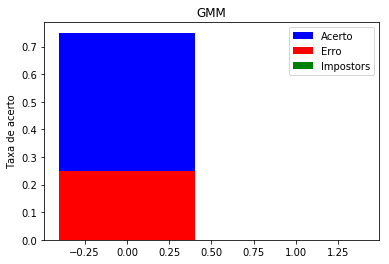

In [28]:
fig, ax = plt.subplots()
rects1 = ax.bar(0, taxa_accepts, color='b')
rects2 = ax.bar(0, taxa_errors, color='r')
rects3 = ax.bar(1, taxa_impostors, color='g')

ax.set_ylabel('Taxa de acerto')
ax.set_title('GMM')
ax.legend((rects1[0], rects2[0], rects3[0]), ('Acerto', 'Erro', 'Impostors'))
plt.show()